# The Key to Life

## Imports and Global Variables

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.externals import joblib

TEST_SIZE = 0.33
LABELS = ["Brian", "Eleanor", "Walt"]
FILES = ["{0}/{1}_{2}".format("keylog_clean_data", name.lower(), "keylogs_clean.csv") for name in LABELS]
DATAFRAMES = []
TRAIN, TEST, DATA_LABELS = None, None, None

## Featurization and Train/Test Split (DO NOT TOUCH)

In [3]:
def featurize_that_bish(df, n, top_pairs=[], frac = 0.01):
    def rand_avg_pairs():
        rand = df.sample(frac=frac)
        data = rand.groupby("pair").mean().reset_index() # random sample here
        if len(top_pairs) > 0:
            data = data.where(data["pair"].isin(top_pairs)).dropna()
        data.columns = ["pair", "delta_avg"]
        data = data.sort_values("pair", ascending=False)
        data = data.transpose()
        data = pd.DataFrame(data)
        data.columns = data.iloc[0]
        data = data.drop(data.index[0])
        return data
    
    final = [pd.DataFrame(columns=top_pairs)]
    for _ in range(n):
        data = rand_avg_pairs()
        final.append(data)
    return pd.DataFrame(create_matrix(final)).fillna(0)

def create_matrix(lst):
    mat = lst[0]
    for mat1 in lst[1:]:
        mat = mat.append(mat1)
    return np.asmatrix(mat)

def format_matrix(mat):
    return np.asmatrix(pd.DataFrame(mat).fillna(0))

def get_top_pairs():
    df = DATAFRAMES[0]
    for df_add in DATAFRAMES[1:]:
        df = df.append(df_add)
    return set(df.groupby("pair").count().sort_values("delta", ascending=False).reset_index()[:100]['pair'])

def get_train_test_labels(dataframes, top_pairs = [], n = 1000):
    n_train = int(n - TEST_SIZE * n)
    n_test = int(n * TEST_SIZE)
    
    train_test = [train_test_split(df, test_size = TEST_SIZE) for df in dataframes]
    featurized = [(featurize_that_bish(pair[0], n_train, top_pairs), featurize_that_bish(pair[1], n_test, top_pairs)) for pair in train_test]
    train_lst, test_lst = zip(*featurized)
    train = format_matrix(create_matrix(train_lst))
    test = format_matrix(create_matrix(test_lst))
    train_labels = get_labels(n_train)
    test_labels = get_labels(n_test)
    return train, train_labels, test, test_labels

def get_labels(n):
    labels = []
    for label in LABELS:
        labels.extend([label for _ in range(n)])
    return labels
        
def create_metrics(clf, train, train_labels, test, test_labels):
    clf.fit(train, train_labels)
    pred = clf.predict(test)
    return classification_report(test_labels, pred), confusion_matrix(test_labels, pred)

def display_confusion_matrix(matrix, labels):
    df_cm = pd.DataFrame(matrix, labels, labels)
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()

def display_metrics(clf, train, train_labels, test, test_labels):
    report, matrix = create_metrics(clf, train, train_labels, test, test_labels)
    print(clf.__class__.__name__)
    print(report)
    display_confusion_matrix(matrix, LABELS)
    
def full_send():
    models = [LogisticRegression, SVC, NuSVC, LinearSVC, RandomForestClassifier, AdaBoostClassifier]
    for model in models:
        display_metrics(model(), TRAIN, TRAIN_LABELS, TEST, TEST_LABELS)

In [11]:
DATAFRAMES = [shuffle(pd.read_csv(file)) for file in FILES]
TRAIN, TRAIN_LABELS, TEST, TEST_LABELS = get_train_test_labels(DATAFRAMES, top_pairs = get_top_pairs())

# Metrics

In [28]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [29]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(TRAIN, TRAIN_LABELS)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.5s
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=30, bootstrap=True, total=   2.5s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=True 


[CV] n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   7.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min


[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   7.3s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=False, total=  16.5s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=90, bootstrap=False, total=   7.5s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=10, bootstrap=False, total=  17.4s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=False 
[CV]  n_estimators=

[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=70, bootstrap=False, total=  13.7s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True, total=   7.9s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  10.5s
[CV] n_estimators=1400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=True, total=  10.5s
[CV] n_estimators

[CV]  n_estimators=800, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=False, total=   6.8s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   4.5s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   7.4s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=90, bootstrap=True, total=  11.0s
[CV] n_estimators=800, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False 
[CV]  n_estimators=1800

[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=   2.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   9.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   9.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=110, bootstrap=True, total=   9.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=False 
[CV]  n_estimators=400, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  6.0min


[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   8.3s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   8.3s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  19.1s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=False, total=  19.4s
[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimat

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=auto, max_depth=80, bootstrap=False, total=   8.3s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  10.1s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  10.4s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=None, bootstrap=False, total=  10.6s
[CV] n_

[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=False, total=   3.6s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   4.1s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False, total=   5.5s
[CV] n_estimators=400, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=1600, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=90, bootstrap=True, total=  13.0s
[CV] n_estimators=1600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=True 
[CV]  n_estimators=1

[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.4s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   5.2s
[CV] n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=sqrt, max_depth=40, bootstrap=False, total=   5.2s
[CV] n_estimators=1600, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=80, bootstrap=True 
[CV]  n_estimators=400, min_samples_split=5, min_samples_leaf=1, max_features=sqrt, max_depth=100, bootstrap=True, total=   2.5s
[CV] n_estimators=1600, mi

[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.7s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=100, bootstrap=False, total=   1.6s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   8.7s
[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False, total=   8.7s
[CV] n_estimators=2000

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.4min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score=True, scoring=None, verbose=2)

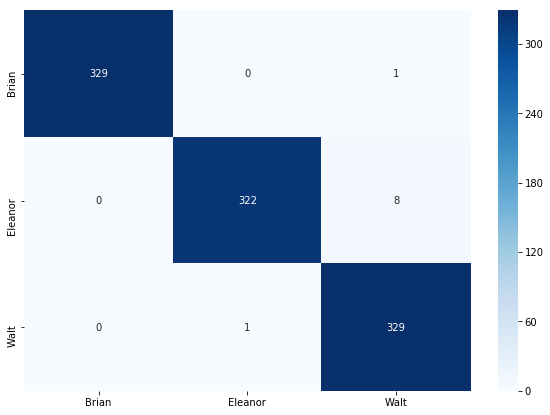

             precision    recall  f1-score   support

      Brian       1.00      1.00      1.00       330
    Eleanor       1.00      0.98      0.99       330
       Walt       0.97      1.00      0.99       330

avg / total       0.99      0.99      0.99       990



In [33]:
pred = rf_random.predict(TEST)
report = classification_report(TEST_LABELS, pred)
display_confusion_matrix(confusion_matrix(TEST_LABELS, pred), LABELS)
print(report)
plt.show()

RandomForestClassifier
             precision    recall  f1-score   support

      Brian       1.00      0.98      0.99       330
    Eleanor       1.00      0.96      0.98       330
       Walt       0.94      1.00      0.97       330

avg / total       0.98      0.98      0.98       990



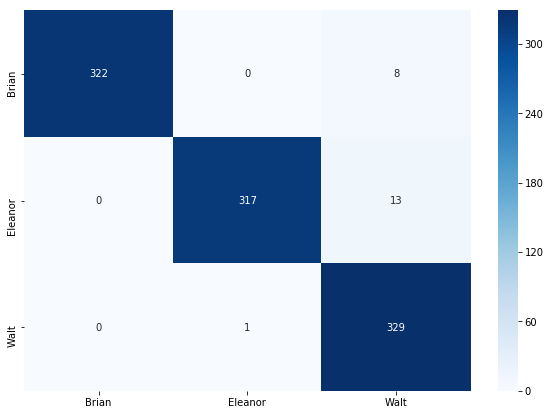

['rf_classifier.pkl']

In [13]:
clf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
display_metrics(clf, TRAIN, TRAIN_LABELS, TEST, TEST_LABELS)
joblib.dump(clf, "rf_classifier.pkl")

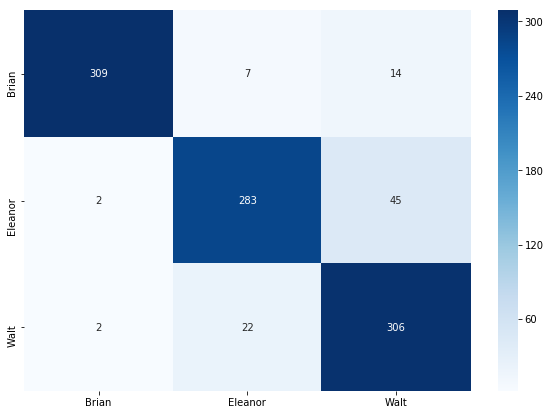

             precision    recall  f1-score   support

      Brian       0.99      0.94      0.96       330
    Eleanor       0.91      0.86      0.88       330
       Walt       0.84      0.93      0.88       330

avg / total       0.91      0.91      0.91       990



In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], "penalty" : ["l1", "l2"] }
log_grid = GridSearchCV(LogisticRegression(), param_grid)
log_grid.fit(TRAIN, TRAIN_LABELS)
pred = log_grid.predict(TEST)
report = classification_report(TEST_LABELS, pred)
display_confusion_matrix(confusion_matrix(TEST_LABELS, pred), LABELS)
print(report)
plt.show()

In [14]:
classifier_file = "rf_classifier.pkl"

clf = joblib.load(classifier_file)

In [15]:
get_top_pairs()

{"'.',Key.space",
 "'a','c'",
 "'a','l'",
 "'a','n'",
 "'a','r'",
 "'a','s'",
 "'a','t'",
 "'a',Key.space",
 "'b','e'",
 "'c','a'",
 "'c','e'",
 "'c','h'",
 "'c','o'",
 "'d','d'",
 "'d','e'",
 "'d',Key.space",
 "'e','a'",
 "'e','c'",
 "'e','d'",
 "'e','e'",
 "'e','l'",
 "'e','n'",
 "'e','r'",
 "'e','s'",
 "'e','t'",
 "'e',Key.space",
 "'f',Key.space",
 "'g',Key.space",
 "'h','a'",
 "'h','e'",
 "'h','i'",
 "'i','n'",
 "'i','o'",
 "'i','s'",
 "'i','t'",
 "'k','e'",
 "'l','a'",
 "'l','e'",
 "'l','i'",
 "'l','l'",
 "'l',Key.space",
 "'m','a'",
 "'m','e'",
 "'n','d'",
 "'n','e'",
 "'n','g'",
 "'n','t'",
 "'n',Key.space",
 "'o','f'",
 "'o','m'",
 "'o','n'",
 "'o','r'",
 "'o','u'",
 "'o',Key.space",
 "'r','a'",
 "'r','e'",
 "'r','i'",
 "'r','o'",
 "'r',Key.space",
 "'s','e'",
 "'s','t'",
 "'s',Key.space",
 "'t','a'",
 "'t','e'",
 "'t','h'",
 "'t','i'",
 "'t','o'",
 "'t',Key.space",
 "'u','r'",
 "'u','t'",
 "'v','e'",
 "'y',Key.space",
 'Key.backspace,Key.backspace',
 'Key.backspace,Key.shift_